# Understanding Differential Attack on a simple SPN

## Encryption Standard and Setup

SPN taken from *"A Tutorial on Linear and Differential Cryptanalysis"* written by **Howard M. Heys**

<div align= "center">
    <img src= "Basic-SPN-cipher.png")>
</div>

In [1]:
from random import Random
from time import time
import numpy as np
import matplotlib.pyplot as plt

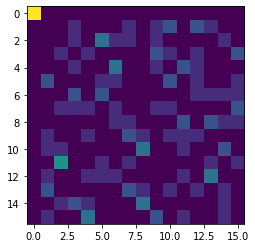

In [2]:
rand= Random()

# STANDARD

SBOX= [0xe, 0x4, 0xd, 0x1,0x2, 0xf, 0xb, 0x8, 0x3, 0xa, 0x6, 0xc, 0x5, 0x9, 0x0, 0x7]
INV_SBOX= [SBOX.index(i) for i in range(16)]

PBOX= [((4*i) %15) for i in range(15)] + [15]
INV_PBOX= [PBOX.index(i) for i in range(16)]

def perm(pbox, cipbits):
    assert len(cipbits) == len(pbox)
    return [cipbits[pbox[i]] for i in range(len(cipbits))]

RDS= 4

# create_new_key= lambda key, round: key^^round

tobits= lambda x, nbits: [*map(int, format(x, "0%db"%nbits)[::-1])]     # little endian
frombits= lambda y: sum(bit*(1<<i) for i,bit in enumerate(y))

def get_ddt(sbox):
    l= len(sbox)
    ddt= np.zeros((l,l), dtype=int)
    for i,x in enumerate(sbox):
        for j,y in enumerate(sbox):
            ddt[i^^j][x^^y]+= 1
    return ddt

DDT= get_ddt(SBOX)
plt.imshow(DDT)
plt.show()

In [3]:
 encrypt(plaintext, key): 
    cipher= plaintext
    for round in range(RDS):      # use 1 round less for probabilistic test of differential characteristic
        cipher ^^= key^^round 
        # print(hex(cipher))

        b= tobits(cipher, 16)
        for j in range(0, len(b), 4): b[j:j+4]= tobits(SBOX[frombits(b[j:j+4])], 4)
        # print(hex(frombits(b)))

        temp= [[]]*16
        for i in range(len(b)): temp[PBOX[i]]= b[i]
        b= temp
        cipher= frombits(b)
        # print(hex(cipher))
    
    cipher ^^= key^^RDS

    return cipher

In [4]:
# test_entry= 0x1234
# test_cipher= encrypt(test_entry, test_key)
# print(hex(test_cipher))

## Brute Force Differential Attack (differential given)

In [5]:
# highlight entire section to toggle comment
# BRUTE FORCE DIFFERENTIAL ATTACK (differential given)

test_key= rand.randint(0, 0xffff)
input_d= 0x0b00
e_output_d= 0x0606        # s-box 2 and 4, from msb
input_d1= 0xa0a0
e_output_d1= 0x8088      # s-box 1, 3, 4, from msb

# probabilistic test with actual key
# start_time= time()
# x= set(); m=[0]*2^8
# for entry in range(15000):
#     x1= rand.randint(0,0xffff)
#     while (x1 in x): x1= rand.randint(0,0xffff)
#     x2= x1^^input_d
#     x.add(x1); x.add(x2); 

#     y1= encrypt(x1, test_key)
#     y2= encrypt(x2, test_key)
    
#     y_diff= tobits(y1^^y2, 16)
#     cha= y_diff[0:4]+y_diff[8:12]
#     m[frombits(cha)]+=1

# print(hex(m.index(max(m))), (max(m)/15000).n())
# print(m)
# print(time()- start_time)

start_time= time()
x= set(); y=[0]*2^8

for entry in range(1000): 
    x1= rand.randint(0, 0xffff)
    while x1 in x: x1= rand.randint(0, 0xffff)
    x2= x1^^input_d
    x.add(x1); x.add(x2); 
    
    y1= encrypt(x1, test_key)
    y2= encrypt(x2, test_key)

    for out in range(2^8):
        temp= [[]]*16
        out_key= tobits(out,8); out_b= []; 
        for i in range(8): out_b+= [out_key[i]]+ [0]     # key-bits fitted due to choice of differential / s-boxes
        out_key= frombits(out_b)

        y1b= tobits(y1^^out_key, 16)
        for i in range(len(y1b)): temp[INV_PBOX[i]]= y1b[i]
        for j in range(0, len(temp), 4): temp[j:j+4]= tobits(INV_SBOX[frombits(temp[j:j+4])],4)
        y1b= frombits(temp)

        y2b= tobits(y2^^out_key, 16)
        for i in range(len(y2b)): temp[INV_PBOX[i]]= y2b[i]
        for j in range(0, len(temp), 4): temp[j:j+4]= tobits(INV_SBOX[frombits(temp[j:j+4])], 4)
        y2b= frombits(temp)

        y_diff= tobits(y1b^^y2b, 16)
        if frombits(y_diff)== e_output_d: y[out]+=1

obtained_bits= []
bt= tobits(y.index(max(y))^^2, 16)
for i in range(8): obtained_bits+= [bt[i]] +[0]

x= set(); y= [0]*2^8; 
for entry in range(1000):
    x1= rand.randint(0, 0xffff)
    while x1 in x: x1= rand.randint(0, 0xffff)
    x2= x1 ^^ input_d1
    x.add(x1); x.add(x2); 

    y1= encrypt(x1, test_key)
    y2= encrypt(x2, test_key)

    for out in range(2^8):
        temp= [[]]*16
        out_key= tobits(out, 8); out_b= []; 
        for i in range(8): out_b+= [obtained_bits[2*i]]+ [out_key[i]]
        out_key= frombits(out_b) ^^4

        y1b= tobits(y1^^out_key, 16)
        for i in range(len(y1b)): temp[INV_PBOX[i]]= y1b[i]
        for j in range(0, len(temp), 4): temp[j:j+4]= tobits(INV_SBOX[frombits(temp[j:j+4])], 4)
        y1b= frombits(temp)

        y2b= tobits(y2^^out_key, 16)
        for i in range(len(y2b)): temp[INV_PBOX[i]]= y2b[i]
        for j in range(0, len(temp), 4): temp[j:j+4]= tobits(INV_SBOX[frombits(temp[j:j+4])], 4)
        y2b= frombits(temp)

        y_diff= tobits(y1b^^y2b, 16)
        if frombits(y_diff)== e_output_d1: y[out]+=1

bt= tobits(y.index(max(y)), 16)
for i in range(8): obtained_bits[2*i+1]= bt[i]      # remaining bits
obtained_key= frombits(obtained_bits)

print(hex(obtained_key), hex(test_key))
print(time()-start_time)
# Success with 1000 pairs at ~45s

0x7108 0x7108
52.23238492012024


## Automatic Search of Differential Characteristic

### Use Convex Hull (no optimization)

In [6]:
def get_sbox_hrep(sbox, threshold:int=0):
    assert threshold >= 0, "Threshold must be a positive integer"
    assert threshold <= len(sbox), "Threshold= `threshold` is larger than SBOX!"
    ddt = get_ddt(sbox)
    l = len(sbox)
    lb = int(l).bit_length()-1
    assert l == 1<<lb, "Size of SBOX isn't a power of two!"   # each successive bit carries an extra weight of *2 => l= max(weight) of bits
    space = []
    for x in range(l):
        for y in range(l):
            if ddt[x,y] <= threshold: continue
            xb = tobits(x, lb)
            yb = tobits(y, lb)
            space.append((*xb, *yb))
    
    p = Polyhedron(vertices=space)
    return p.Hrepresentation()

In [7]:
def hrep_to_ineq(hrep, lin_var):
    assert len(lin_var) == len(hrep[0]) - 1, \
        "Number of arguments does not match dimensionality of `hrep`"
    # hrep includes constant b in iterable as element 0
    return [
        sum(var*coeff for coeff,var in zip([*ieq][1:], lin_var)) + ieq.b() >= 0 
        for ieq in hrep
    ]
    # 1.    The function pushes '*' multiply operator. MIP linear function (lf) 
    #       attaches real constants to variables for storage as lf object. 
    # 2.    '>=', __geq__ has been overwritten to read 2 lf and output some 
    #       linear constraint (lc), thus NOT a boolean
    # 3.    Returns a list of constraints

In [8]:
def toblks(arr, blocklen:int):
    assert len(arr)%blocklen ==0, "`blocklen` isn't a divisor of `len(arr)`"
    return [arr[i : i + blocklen] for i in range(0, len(arr), blocklen)]

In [9]:
class VarGen:
    
    """
    Wrapper class over `solver.new_variable`
    to provide the `gen` method
    """
    
    def __init__(self, solver:MixedIntegerLinearProgram):
        self.vargen = solver.new_variable(integer=True)
        
    def __getitem__(self, idx):
        """Get an existing variable at index `idx`"""
        assert idx < len(self.vargen.keys())
        return self.vargen[idx]
    
    def gen(self):
        """Generates a new variable"""
        return self.vargen[len(self.vargen.keys())]

In [10]:
# Forming the MILP
hrep_sbox= get_sbox_hrep(SBOX, 2)

solver= MixedIntegerLinearProgram(maximization=False)
vargen= VarGen(solver)

pt= [vargen.gen() for i in range(16)]  # generates a new variable point with each indexing imposed
ct= pt[:]   # first round of ciphertext = plaintext
solver.add_constraint(sum(pt) >=1)    # only non-trivial solutions

In [11]:
# for just 1 round

# ct= [vargen.gen() for i in range(16)]

# sboxcons= [
#     hrep_to_ineq(
#         hrep, 
#         pt[n*4: n*4 +4] + ct[n*4: n*4+4])
#     for n in range(4)
# ]   # generates constraints of 1 sbox and apply to all sboxes
# for sc in sboxcons: 
#     for c in sc: solver.add_constraint(c)

In [12]:
sbox_ins= []    # Saves all s-box input var
sbox_outs= []   # Saves all s-box output var

# for each round, add the constraints associated to permutated bit
for rd in range(RDS-1):

    # saves the cipher bit-variable order before entering s-box
    sbox_ins.extend(toblks(ct, 4))  
    # each element is block of cipher => len(sbox_ins)= total number of sboxes

    # a fresh blk at end of each sbox
    sbox_out= [vargen.gen() for i in range(16)] 
    # save the assigned constraint variables in this sbox output
    sbox_outs.extend(toblks(sbox_out, 4))

    for c_blk, out_blk in zip(toblks(ct, 4), toblks(sbox_out, 4)):  # for each sbox, 
        for c in hrep_to_ineq(hrep_sbox, c_blk + out_blk):          # generate the ieqs
            solver.add_constraint(c)                               # and add to constraints

    # permutate before next round
    ct= perm(PBOX, sbox_out)


for self to understand the ***above code***:

Begin each iteration with 16 unique variables whose boolean values are FIXED from before encryption to after encryption. 

Over n rounds, the variables are just being permuted and shifted around, hence the indexing of the variables after any round may not be the same. But inherently each variable still holds the same value. E.g. [x0, x1, x2, x3] -> [x2, x0, x3, x1]. 
this movement represents the permutation of bits

The fixed value of the variables are restricted by valid differentials of the s-box. The restrictions are represented as constraints of MILP. 
(constraints thus represent all valid differentials) 

Iterate for all possible sets of 16 unique variables.

In [13]:
frombits(pt)

x_0 + 2*x_1 + 4*x_2 + 8*x_3 + 16*x_4 + 32*x_5 + 64*x_6 + 128*x_7 + 256*x_8 + 512*x_9 + 1024*x_10 + 2048*x_11 + 4096*x_12 + 8192*x_13 + 16384*x_14 + 32768*x_15

One possible way to set objective function: 

In [14]:
# # active_s= [vargen[i] for i in range(4)]
# active_s= [vargen.gen() for i in range(len(sbox_ins))]

# # identify active s-boxes
# for sbox in range(len(sbox_ins)):
#     solver.add_constraint(active_s[sbox] <=1)     # boolean variable
#     for bit in sbox_ins[sbox]:
#         solver.add_constraint(active_s[sbox]>= bit) 

# # for bit in range(len(pt)):
# #     solver.add_constraint(active_s[bit//4] >=pt[bit])

Another way to set objective function:

In [15]:
from inspect import signature
from itertools import product
# product(n sets): 
# product is the cartesian product of sets A1, A2, ..., An, 
# where the sets are taken as inputs.
# `repeat=k` can be used to repeat the same set used in the Cartesian 
# product for k times. 
# E.g. product([0,1], [2,3]) => [0,2] , [0,3] , [1,2] , [1,3]

def get_boolexpr_hrep(boolfunc):
    """
    Get H-Representation of points representing
    (a0,a1,...,an, boolfunc(a0,a1,...,an))
    
    boolfunc is a boolean function of n-args with a boolean output
    """
    nargs = len(signature(boolfunc).parameters)
    space = []
    for nb in product([0,1], repeat=nargs): # all possible binary vectors in n-d
        space.append((*nb, boolfunc(*nb)))
        
    p = Polyhedron(vertices=space)  # entire space based on the defined bool func
    return p.Hrepresentation()

hrep_activeS= get_boolexpr_hrep(lambda a,b,c,d: a or b or c or d)
active_s= [vargen.gen() for _ in range(len(sbox_ins))]

# add constraints to enable active s-box
for sbox_in, active in zip(sbox_ins, active_s):
    for c in hrep_to_ineq(hrep_activeS, sbox_in + [active]):
        solver.add_constraint(c)

A solution is given below. 

In [16]:
objective= sum(active_s)
solver.set_objective(objective)

# solver.show()
min_s=  solver.solve()
print("Minimum Active S-Boxes:", min_s)

Minimum Active S-Boxes: 4.0


In [17]:
d_in= [*map(int, solver.get_values(pt))]
d_out= [*map(int, solver.get_values(ct))]

sbox_i=[]
for inp in toblks(sbox_ins, 4):     # every 4 sublists is 1 chain of ciphertext
    sbox_i+= [[*map(int, solver.get_values( sum(inp, [])) )]]
sbox_o=[]
for oup in toblks(sbox_outs, 4):
    sbox_o+= [[*map(int, solver.get_values( sum(oup, [])) )]]
# sum(nested list, []) converts sum into joining of lists inside an iterable


print("Plaintext Difference: ")
print(d_in, hex(frombits(d_in)))

print("\nS-Box I/O: ")
for i,o in zip(sbox_i, sbox_o): 
    print(" I:", i, hex(frombits(i)))
    print(" O:", o, hex(frombits(o)))
    print(" "+ "-"*24 + "PERMUTATE" + "-"*25)


print("\nCiphertext Difference: ")
print(d_out, hex(frombits(d_out)))

Plaintext Difference: 
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0] 0xe00

S-Box I/O: 
 I: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0] 0xe00
 O: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] 0x800
 ------------------------PERMUTATE-------------------------
 I: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 0x4000
 O: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0] 0x6000
 ------------------------PERMUTATE-------------------------
 I: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0] 0x880
 O: [0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0] 0xbd0
 ------------------------PERMUTATE-------------------------

Ciphertext Difference: 
[0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0] 0x6246


In [18]:
# Compute the probability of differential trail
from functools import reduce
help(reduce)

Help on built-in function reduce in module _functools:

reduce(...)
    reduce(function, sequence[, initial]) -> value
    
    Apply a function of two arguments cumulatively to the items of a sequence,
    from left to right, so as to reduce the sequence to a single value.
    For example, reduce(lambda x, y: x+y, [1, 2, 3, 4, 5]) calculates
    ((((1+2)+3)+4)+5).  If initial is present, it is placed before the items
    of the sequence in the calculation, and serves as a default when the
    sequence is empty.



In [19]:
prod= lambda arr: reduce(lambda x,y: x*y, arr)
p_rd= []
for i,o in zip(sbox_i, sbox_o):
    p_rd+= [ prod( DDT[frombits(iblk), frombits(oblk)]/len(SBOX) for iblk, oblk in  zip(toblks(i,4), toblks(o,4)) )]

print(p_rd)
p_trail= prod(p_rd)
print("Probability of Differential Characteristic: ", (p_trail))
print(" - One in", int(round(1/p_trail)))

[0.375, 0.375, 0.0625]
Probability of Differential Characteristic:  0.0087890625
 - One in 114
